In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import Audio,Image
from PIL import Image as PIL_Image
import multiprocessing
from joblib import Parallel,delayed
import gc, pickle

import os,sys
os.system("taskset -p 0xff %d" % os.getpid())
sys.path.append(os.path.expanduser('~')+'/audio_class/python')
sys.path.append('../../audio_class/python')
import audio_class
import ridgeDTW
import delay2loc
import audio_loc

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATAROOT = './BBSPjun5_13/'

In [3]:
# load mics' locations
micsloc = []
with open('micloc1.csv','r') as fid:
    for lines in fid:
        tokens = lines.split(',')
        micsloc.append([float(tokens[0]),float(tokens[1]),float(tokens[2])])
micsloc = np.array(micsloc)
print('micsloc = %s' % micsloc)

micsloc = [[-39.624   -3.048    3.048 ]
 [-30.48     0.       3.048 ]
 [-21.336    0.       0.9144]
 [-12.192   -3.048    0.9144]
 [ -3.048   -3.048    3.048 ]
 [  6.096    0.       3.048 ]
 [ 15.24    -3.048    0.9144]
 [ 24.384    0.       0.9144]]


In [4]:
########## Work on a single recording first
fs,data = audio_class.readSegment(DATAROOT+'day2-1370485107.wav')
NCh,NDat = np.shape(data)

In [5]:
print('fs = %s' % fs)
print('NCh = %s, NDat = %s' % (NCh,NDat))
#Audio(data[0,:],rate=fs)

fs = 44100
NCh = 8, NDat = 2646000


In [21]:
# hierarchical processing
tHieBlk=[0.032,0.256]
tHieInc=[0.004,0.032]
hRidges,hSpecs = audio_loc.hieProc(data,fs,tHieBlk,tHieInc)

In [6]:
#with open('./hRidges_hSpecs.pkl','wb') as fid:
#    pickle.dump((hRidges,hSpecs),fid)
#with open('./hRidges_hSpecs.pkl','rb') as fid:
#    hRidges,hSpecs = pickle.load(fid)

True
n1 = 0, n2 = 1879


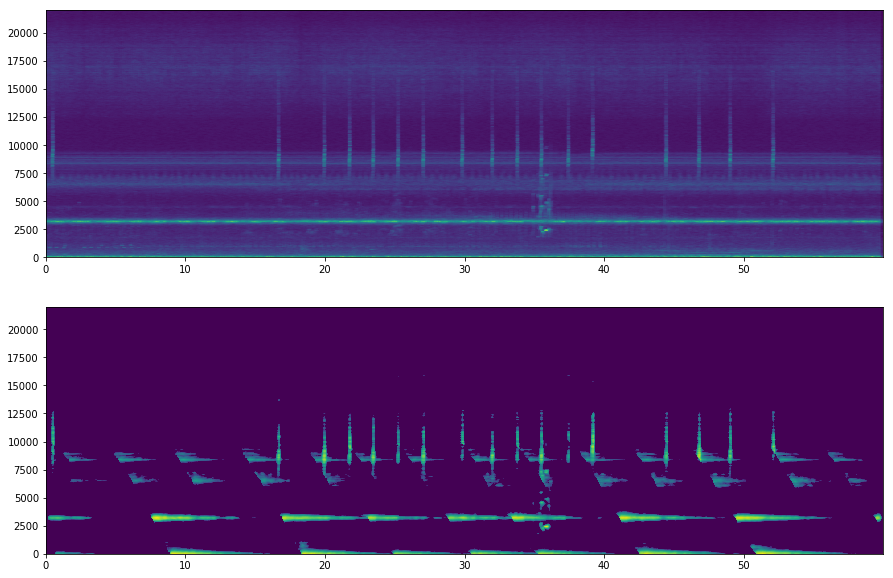

In [7]:
level = 1
chIdx = 7
S,F,T,tBlk,tInc = hSpecs[level][chIdx]
X = hRidges[level][chIdx]
print(tInc == T[1]-T[0])
n1 = int(0/tInc)
n2 = int(60/tInc)
print('n1 = %s, n2 = %s' % (n1,n2))

plt.figure(figsize=(15,10))
plt.subplot(211)
plt.pcolormesh(T[n1:n2],F,np.sqrt(S[:,n1:n2]))
plt.subplot(212)
plt.pcolormesh(T[n1:n2],F,np.sqrt(X[:,n1:n2]))

In [10]:
tSegBlk = 2.
tSegInc = 1.

In [ ]:
# per-channel cross-level processing
gc.collect()

def xLevelProc(k,hRidges,hSpecs,tSegBlk,tSegInc):
    # per channel inputs
    Xh = hRidges[1][k]
    _,_,_,_,thInc = hSpecs[1][k]
    Xl = hRidges[0][k]
    _,_,_,_,tlInc = hSpecs[0][k]
    #print(thInc/tlInc)
    
    # Segmenting for causal/online processing 
    # and reduce computational load
    XhSegs,tSegBlk,tSegInc = audio_loc.segment(Xh,tSegBlk,tSegInc,thInc)
    #print('np.shape(XhSegs) = %s' % (np.shape(XhSegs),))
    lObjsAll = [None]*len(XhSegs)
    for l in range(30,40):#len(XhSegs)):
        # extract high-level objects
        hObjs = audio_loc.labelObjects(XhSegs[l])
        hObjs = audio_loc.pruneObj(hObjs)
        #print('np.shape(hObjs) = %s' % (np.shape(hObjs),))
        
        # extract low-level objects given high-level ones as masks
        n0,n1 = audio_loc.seg2bounds(l,tSegBlk,tSegInc,tlInc)
        XX = Xl[:,n0:n1]
        
        # debugging plots
        '''
        plt.figure()
        plt.subplot(211)
        plt.pcolormesh(XhSegs[l])
        plt.ylabel('XhSegs[l]')
        plt.subplot(212)
        plt.pcolormesh(XX)
        plt.ylabel('XX')
        '''
        
        lObjsGrp = [None]*len(hObjs)
        for i in range(len(hObjs)):
            # temporal upsampling with 
            # thInc: higher level time increment/scale
            # tlInc: lower level time increment/scale
            mask = np.repeat(hObjs[i],int(thInc/tlInc),axis=1)
            mask[mask > 0] = 1.
            '''
            print(np.shape(XX))
            print(np.shape(mask))
            plt.figure()
            plt.pcolormesh(mask)
            plt.ylabel('mask')
            '''
            lObjs = audio_loc.labelObjects(mask*np.pad(XX,((0,0),(0,mask.shape[1]-XX.shape[1])),'constant'))
            lObjs = audio_loc.pruneObj(lObjs)
            
            # all low-level objects belong to the same group
            lObjsGrp[i] = lObjs
        print('np.shape(lObjsGrp) = %s' % (np.shape(lObjsGrp),))
        '''
        plt.figure()
        plt.pcolormesh(lObjsGrp[0][0])
        '''
        
        lObjsAll[l] = lObjsGrp
        
    return lObjsAll
        
lObjsAllCh = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(xLevelProc)\
            (k,hRidges,hSpecs,tSegBlk,tSegInc) for k in range(NCh))
# swap channel and temporal segment index 
# to streamline subsequent multichannel processing
lObjsAllCh = np.swapaxes(lObjsAllCh,0,1)

print('np.shape(lObjsAllCh) = %s' % (np.shape(lObjsAllCh),))

In [7]:
#with open('./lObjsAllCh.pkl','wb') as fid:
#    pickle.dump(lObjsAllCh,fid)
#with open('./lObjsAllCh.pkl','rb') as fid:
#    lObjsAllCh = pickle.load(fid)

(61, 8)
(3,)
(6, 512, 682)


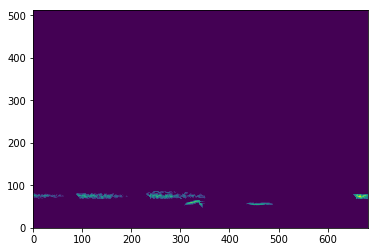

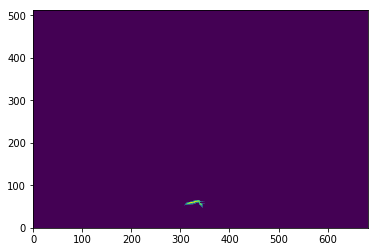

In [8]:
segIdx = 35 # audio segment/clip index
chIdx = 7 # channel index
grpIdx = 1 # group (of objects) index
objIdx = 0 # object index
print(np.shape(lObjsAllCh))
print(np.shape(lObjsAllCh[segIdx][chIdx])) # num of groups
print(np.shape(lObjsAllCh[segIdx][chIdx][grpIdx])) # num of objects

plt.figure()
plt.pcolormesh(np.mean(lObjsAllCh[segIdx][chIdx][grpIdx],axis=0))
plt.figure()
plt.pcolormesh(lObjsAllCh[segIdx][chIdx][grpIdx][objIdx])

In [9]:
# generates 3D images of our environment
# refs: TRTimage.py from mpop
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h, 4 ) # quick reshape
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf
# refs: http://stackoverflow.com/questions/11140163/python-matplotlib-plotting-a-3d-cube-a-sphere-and-a-vector
def draw_ball(axes,cen,rad,color='r'):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = rad[0]*np.cos(u)*np.sin(v)
    y = rad[1]*np.sin(u)*np.sin(v)
    z = rad[2]*np.cos(v)
    axes.plot_wireframe(cen[0]+x,cen[1]+y,cen[2]+z,color=color)

In [27]:
# forming and working with groups
grps = np.zeros(np.shape(lObjsAllCh),dtype=object)
for segIdx in range(30,40):
    #print('==========')
    for chIdx in range(NCh):
        grps[segIdx,chIdx] = []
        for grpIdx in range(len(lObjsAllCh[segIdx,chIdx])):
            for objIdx in range(len(lObjsAllCh[segIdx,chIdx][grpIdx])):
                grps[segIdx,chIdx].append(lObjsAllCh[segIdx,chIdx][grpIdx][objIdx])
        grps[segIdx,chIdx] = np.array(grps[segIdx,chIdx])
        #print(np.shape(grps[segIdx,chIdx]))

nIter = 1, mu = 1000.0, grad = [-0.00921302 -0.00026349 -0.01079241], loc = [  12.94404423    5.74959531  253.41105322], err = 0.303893743603
nIter = 2, mu = 1000.0, grad = [-0.00810461 -0.00020865 -0.00880964], loc = [  22.15706145    6.01308955  264.20346446], err = 0.238865805534
nIter = 3, mu = 1000.0, grad = [-0.00691848 -0.00011264 -0.00772134], loc = [  30.26167495    6.22174444  273.01310447], err = 0.195442000412
nIter = 4, mu = 1000.0, grad = [ -2.84874088e-03   2.02693067e-05  -7.49579512e-03], loc = [  37.18015877    6.33438354  280.73444005], err = 0.17606068991
nIter = 5, mu = 1000.0, grad = [ -2.74275130e-03   3.47070842e-05  -6.92024636e-03], loc = [  40.02889965    6.31411423  288.23023517], err = 0.172808181152
nIter = 6, mu = 1000.0, grad = [ -2.65494548e-03   4.55946347e-05  -6.46454771e-03], loc = [  42.77165096    6.27940715  295.15048154], err = 0.169753396336
nIter = 7, mu = 1000.0, grad = [ -1.89903219e-03   5.13348716e-05  -6.22211435e-03], loc = [  45.4265964

nIter = 214, mu = 62.5, grad = [-0.00059523 -0.00012316 -0.00357959], loc = [  63.01309028   10.89082264  397.93675158], err = 0.20889385089
nIter = 215, mu = 62.5, grad = [-0.00059467 -0.00012305 -0.00357621], loc = [  63.05029194   10.89852     398.16047587], err = 0.20888712366
nIter = 216, mu = 62.5, grad = [-0.00059411 -0.00012294 -0.00357284], loc = [  63.08745856   10.90621056  398.38398886], err = 0.208880410288
nIter = 217, mu = 62.5, grad = [-0.00059355 -0.00012283 -0.00356948], loc = [  63.12459023   10.91389436  398.60729119], err = 0.20887371072
nIter = 218, mu = 62.5, grad = [-0.00059299 -0.00012272 -0.00356613], loc = [  63.16168706   10.9215714   398.83038347], err = 0.208867024903
nIter = 219, mu = 62.5, grad = [-0.00059244 -0.00012262 -0.00356279], loc = [  63.19874915   10.92924171  399.05326634], err = 0.208860352785
nIter = 220, mu = 62.5, grad = [-0.00059189 -0.00012251 -0.00355945], loc = [  63.23577661   10.93690531  399.2759404 ], err = 0.208853694314
nIter = 2

nIter = 400, mu = 62.5, grad = [-0.0005581  -0.00010687 -0.00313502], loc = [  69.83187388   12.2183688   436.82154458], err = 0.207822237725
nIter = 401, mu = 62.5, grad = [-0.00055771 -0.0001068  -0.00313285], loc = [  69.86675494   12.22504812  437.01748363], err = 0.207817282313
nIter = 402, mu = 62.5, grad = [-0.00055732 -0.00010673 -0.00313067], loc = [  69.90161181   12.23172303  437.21328659], err = 0.207812334785
nIter = 403, mu = 62.5, grad = [-0.00055694 -0.00010666 -0.00312851], loc = [  69.93644453   12.23839355  437.40895378], err = 0.20780739512
nIter = 404, mu = 62.5, grad = [-0.00055655 -0.00010659 -0.00312634], loc = [  69.97125315   12.24505968  437.60448548], err = 0.207802463293
nIter = 405, mu = 62.5, grad = [-0.00055617 -0.00010652 -0.00312419], loc = [  70.00603773   12.25172143  437.79988198], err = 0.207797539284
nIter = 406, mu = 62.5, grad = [-0.00055579 -0.00010645 -0.00312203], loc = [  70.04079832   12.25837881  437.99514357], err = 0.207792623069
nIter =

nIter = 616, mu = 62.5, grad = [ -4.89938414e-04  -9.44121585e-05  -2.75180261e-03], loc = [  76.87716013   13.57183716  476.39474015], err = 0.206904240704
nIter = 617, mu = 62.5, grad = [ -4.89680361e-04  -9.43648018e-05  -2.75035188e-03], loc = [  76.90778128   13.57773792  476.56672782], err = 0.206900584199
nIter = 618, mu = 62.5, grad = [ -4.89422729e-04  -9.43175210e-05  -2.74890352e-03], loc = [  76.9383863    13.58363572  476.73862481], err = 0.20689693226
nIter = 619, mu = 62.5, grad = [ -4.89165518e-04  -9.42703159e-05  -2.74745752e-03], loc = [  76.96897522   13.58953057  476.91043128], err = 0.206893284879
nIter = 620, mu = 62.5, grad = [ -4.88908727e-04  -9.42231862e-05  -2.74601389e-03], loc = [  76.99954807   13.59542246  477.08214737], err = 0.206889642045
nIter = 621, mu = 62.5, grad = [ -4.88652354e-04  -9.41761318e-05  -2.74457261e-03], loc = [  77.03010486   13.60131141  477.25377324], err = 0.206886003748
nIter = 622, mu = 62.5, grad = [ -4.88396398e-04  -9.412915

nIter = 831, mu = 62.5, grad = [ -4.42580653e-04  -8.56945818e-05  -2.48558784e-03], loc = [  83.12730953   14.77919005  511.49788749], err = 0.20620896698
nIter = 832, mu = 62.5, grad = [ -4.42392315e-04  -8.56598016e-05  -2.48452922e-03], loc = [  83.15497082   14.78454596  511.65323673], err = 0.206206102336
nIter = 833, mu = 62.5, grad = [ -4.42204225e-04  -8.56250661e-05  -2.48347199e-03], loc = [  83.18262034   14.7898997   511.8085198 ], err = 0.206203240651
nIter = 834, mu = 62.5, grad = [ -4.42016382e-04  -8.55903754e-05  -2.48241615e-03], loc = [  83.21025811   14.79525127  511.9637368 ], err = 0.206200381922
nIter = 835, mu = 62.5, grad = [ -4.41828785e-04  -8.55557294e-05  -2.48136170e-03], loc = [  83.23788413   14.80060067  512.11888781], err = 0.206197526141
nIter = 836, mu = 62.5, grad = [ -4.41641435e-04  -8.55211278e-05  -2.48030863e-03], loc = [  83.26549843   14.8059479   512.27397292], err = 0.206194673305
nIter = 837, mu = 62.5, grad = [ -4.41454330e-04  -8.548657

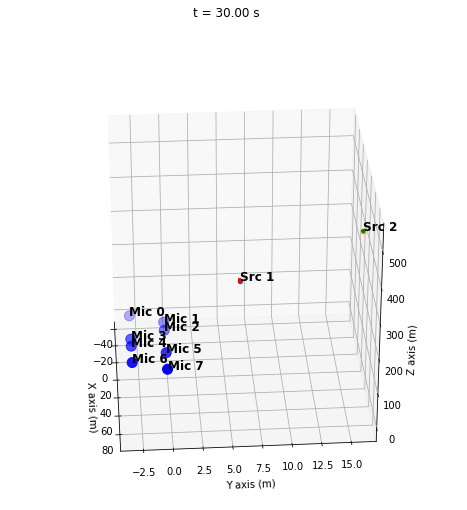

In [28]:
_,_,_,_,tInc = hSpecs[0][0]
colors = 'rgymc'
colIdx = 0
mu = 1e3
images = []
durations = [] # ms
for segIdx in range(30,31):
    # draw pic frame
    fig = plt.figure(figsize=(8,8))
    axes = fig.gca(projection='3d')
    #axes.set_aspect("equal")
    #print(np.shape(grps[segIdx]))
    
    srcCnt = 0
    while True:
        # generate output for each channel
        # find the most overlapped set of groups
        seq = audio_loc.bestLink(grps[segIdx])
        #print(seq)
        if len(seq) == 0:
            break
        '''
        plt.figure(figsize=(10,15))
        for chIdx in range(NCh):
            plt.subplot(NCh,1,chIdx+1)
            plt.pcolormesh(grps[segIdx,chIdx][seq[chIdx]])
        '''

        #print('==========')
        srcCnt += 1
        # form the measurement matrix, i.e.
        # measure the delays in matrix form
        meas_delayMat = np.zeros((NCh,NCh))
        for k in range(NCh):
            for l in range(k+1,NCh):
                corr = audio_loc.gramCorr(grps[segIdx,k][seq[k]],grps[segIdx,l][seq[l]],NInc=100)
                '''
                print(np.argmax(corr))
                plt.figure()
                plt.plot(corr)
                '''
                meas_delayMat[k,l] = tInc*(np.argmax(corr)-len(corr)//2)
                meas_delayMat[l,k] = -meas_delayMat[k,l]
        #print(meas_delayMat)
        
        # localize the source from the given delay measurement
        #print('meas_delayMat = %s' % meas_delayMat)
        loc,err,grad = delay2loc.delay2loc_grad(micsloc,meas_delayMat,mu=mu,debug=True)
        #print('loc = %s, grad = %s' % (loc,grad))
        axes.scatter(loc[0],loc[1],loc[2])
        axes.text(loc[0],loc[1],loc[2],'Src %d' % srcCnt,fontweight='bold',fontsize='large')
        draw_ball(axes,loc,mu*grad,color=colors[colIdx%len(colors)])
        colIdx += 1
        
        # remove the connected groups
        audio_loc.rmGrp(grps[segIdx],seq)
        '''
        # sanity check of grps
        for chIdx in range(NCh):
            print(np.shape(grps[segIdx,chIdx]))
        '''

    axes.scatter(micsloc[:,0],micsloc[:,1],micsloc[:,2],s=100,c='b')
    for k in range(NCh):
        axes.text(micsloc[k,0],micsloc[k,1],micsloc[k,2],'Mic %s' % k,
                  fontweight='bold',fontsize='large')

    axes.set_xlabel('X axis (m)')
    #axes.set_xlim([-50,30])
    axes.set_ylabel('Y axis (m)')
    #axes.set_ylim([-5,10])
    axes.set_zlabel('Z axis (m)')
    #axes.set_zlim([0,10])
    
    fig.suptitle('t = %.2f s' % (segIdx*tSegInc))

    # draw with rotating azimuth angle
    for angle in range(0,360,4):
        axes.view_init(30, angle)
        imData = fig2data(fig)
        w,h,d = imData.shape
        im = PIL_Image.frombytes('RGBA',(w,h),imData)
        images.append(im)
        durations.append(100)

In [29]:
delays,_ = delay2loc.estDelay(micsloc,loc)
delayMat = delay2loc.toMat(delays)
err = 0.5*np.sum(np.abs(delayMat-meas_delayMat))
print('delayMat = \n%s' % delayMat)
print('meas_delayMat =\n%s' % meas_delayMat)
print('err = %s' % err)

print('dist = %s' % np.linalg.norm(loc-np.mean(micsloc,axis=0)))

delayMat = 
[[ 0.         -0.00630226 -0.00574897 -0.01060688 -0.02149387 -0.02605964
  -0.02339574 -0.02705575]
 [ 0.00630226  0.          0.00055329 -0.00430462 -0.01519161 -0.01975738
  -0.01709349 -0.0207535 ]
 [ 0.00574897 -0.00055329  0.         -0.00485791 -0.0157449  -0.02031067
  -0.01764677 -0.02130678]
 [ 0.01060688  0.00430462  0.00485791  0.         -0.01088699 -0.01545276
  -0.01278886 -0.01644887]
 [ 0.02149387  0.01519161  0.0157449   0.01088699  0.         -0.00456577
  -0.00190187 -0.00556188]
 [ 0.02605964  0.01975738  0.02031067  0.01545276  0.00456577  0.
   0.0026639  -0.00099611]
 [ 0.02339574  0.01709349  0.01764677  0.01278886  0.00190187 -0.0026639
   0.         -0.00366001]
 [ 0.02705575  0.0207535   0.02130678  0.01644887  0.00556188  0.00099611
   0.00366001  0.        ]]
meas_delayMat =
[[ 0.         -0.00870748 -0.01160998 -0.01160998 -0.00870748 -0.02031746
  -0.02031746 -0.02031746]
 [ 0.00870748  0.         -0.01451247 -0.01160998 -0.00870748 -0.020317

In [ ]:
# sanity checks
size = fig.get_size_inches()*fig.dpi # size in pixels
size = tuple(size.astype(int))
print(size)
#print('(%s, %s)' % (w,h))
print(size == (w,h))

print(images[0])
plt.figure(figsize=(8,16))
plt.subplot(211)
plt.imshow(images[0])
plt.subplot(212)
plt.imshow(images[1])

In [46]:
# Animate
gif_pathname = 'images/micsloc_srcloc.gif'
gif = images[0]
#gif.info['duration'] = tuple([100]*len(images)) # ms per frame
gif.info['duration'] = tuple(durations)
gif.info['loop'] = 0 # how many times to loop (0=infinite)
gif.save(fp=gif_pathname, format='gif', save_all=True, append_images=images[1:])

# verify that the number of frames in the gif equals the number of image files and durations
print(len(images))
print(PIL_Image.open(gif_pathname).n_frames == len(images))

# might need to refresh the page to reload the image,
# according to https://github.com/jupyter/notebook/issues/1369
Image(url=gif_pathname)

90
True


In [ ]:
########## Work on all recordings
'''
for file in os.listdir(DATAROOT):
    print(file)
    fs,data = audio_class.readSegment(DATAROOT+file)
    break
'''